# Support for spatial transcriptomics

For more information on the support for spatial transcriptomics, please see the [SPArrOW documentation](https://sparrow-pipeline.readthedocs.io/en/latest). Harpy focusses on the analysis of spatial proteomics data and extends the SPArrOW pipeline to support highly-multiplexed images.

In [2]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.

import harpy as hp

## 1. Read in the data

The first step includes reading in the raw data.

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`.


### Convert to zarr and read the image


In [4]:
import os
import tempfile
import uuid

from spatialdata import SpatialData
from spatialdata import read_zarr

from harpy.datasets.registry import get_registry

from dask_image import imread

# change this path. It is the directory where the spatialdata .zarr will be saved.
OUTPUT_DIR = tempfile.gettempdir()

img_layer = "raw_image"

path = None  # If None, example data will be downloaded in the default cache folder of your os. Set this to a custom path, to change this behaviour.
registry = get_registry(path=path)
path_image = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff")

# you can choose any name for your zarr file
output_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata = SpatialData()
sdata.write(output_path)
sdata = read_zarr(sdata.path)

arr = imread.imread(path_image)

sdata = hp.im.add_image_layer(
    sdata,
    arr=arr.rechunk(1024),
    output_layer=img_layer,
    c_coords="DAPI",
)
sdata

2025-11-12 08:51:11,225 - harpy.image._manager - INFO - Writing results to layer 'raw_image'


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_d4046b58-9ead-471e-b0ff-c46ad79d6398.zarr
└── Images
      └── 'raw_image': DataArray[cyx] (1, 12864, 10720)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images)

## 2. Plot the image


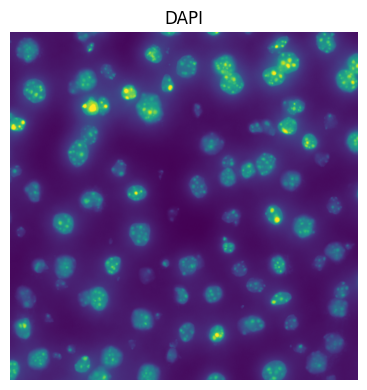

In [ ]:
import numpy as np
from harpy.image._image import _get_spatial_element
import dask.array as da
from matplotlib.colors import Normalize

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
channel = "DAPI"
crd = [3000, 4000, 3000, 4000]  # visualize a crop

# normalization parameters for visualization (underlying image not changed)
# for visualization we normalize by the 99th percentile
se = _get_spatial_element(sdata, layer=img_layer)
_channel_idx = np.where(sdata[img_layer].c.data == channel)[0].item()
vmax = da.percentile(se.data[_channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "viridis", "norm": norm}
show_kwargs = {"title": channel, "colorbar": False}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)
# frameless figure
ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Segment using Cellpose


In [9]:
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),#
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)

sdata = hp.im.segment(
    sdata,
    img_layer="raw_image",
    depth=200,
    model=cellpose_callable,
    # parameters that will be passed to the callable cellpose_callable
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)
client.close()

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50909 instead
  warnings.warn(


http://127.0.0.1:50909/status


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more tha

## 4. Visualize resulting segmentation

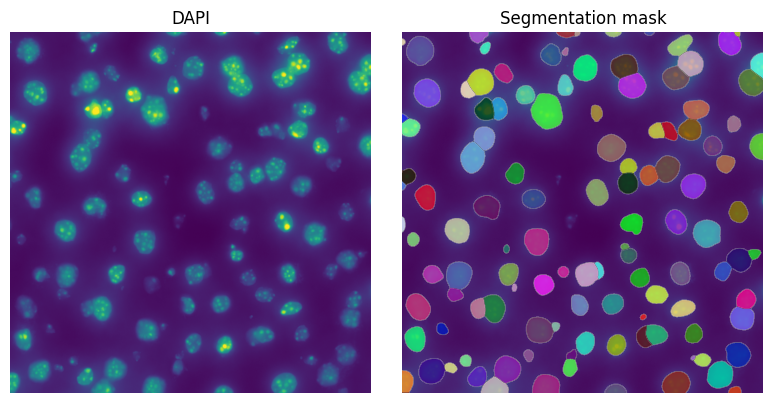

In [14]:
import numpy as np
from harpy.image._image import _get_spatial_element
import dask.array as da
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
img_layer = "raw_image"
labels_layer = "segmentation_mask"
crd = [3000, 4000, 3000, 4000]

# normalization parameters for visualization (underlying image not changed)
se = _get_spatial_element(sdata, layer=img_layer)
channel_idx = np.where(sdata[img_layer].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "viridis", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {"title": channel, "colorbar": False}
_ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer=img_layer,
    crd=crd,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {"title": "Segmentation mask", "colorbar": False}
_ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    crd=crd,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

## 5. Create AnnData table

In [15]:
# read in the points
path_transcripts = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_results.txt")
sdata = hp.io.read_resolve_transcripts(sdata, path_count_matrix=path_transcripts, output_layer="transcripts")
sdata

2025-11-12 08:57:31,357 - harpy.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2025-11-12 08:57:31,357 - harpy.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_d4046b58-9ead-471e-b0ff-c46ad79d6398.zarr
├── Images
│     └── 'raw_image': DataArray[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (121, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), segmentation_mask_boundaries (Shapes)

In [16]:
sdata = hp.tb.allocate(
    sdata,
    labels_layer="segmentation_mask",
    points_layer="transcripts",
    output_layer="table_transcriptomics",
    overwrite=True,
)
sdata["table_transcriptomics"]

2025-11-12 08:57:38,316 - harpy.table._allocation - INFO - Calculating cell counts.
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
2025-11-12 08:57:38,829 - harpy.shape._manager - INFO - Filtering 2 cells from shapes layer 'segmentation_mask_boundaries'. Adding new shapes layer 'filtered_segmentation_segmentation_mask_boundaries' containing these filtered out polygons.
2025-11-12 08:57:38,910 - harpy.utils._io - WARNING - layer with name 'segmentation_mask_boundaries' already exists. Overwriting...


AnnData object with n_obs × n_vars = 119 × 71
    obs: 'cell_ID', 'fov_labels'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [20]:
sdata["table_transcriptomics"].to_df().head()

,Adamtsl2,Adgre1,Atp6v0d2,Axl,C5ar1,Ccr2,Cd207,Cd209a,Cd36,Cd3e,...,Sox9,Spn,Spon2,Stab2,Timd4,Tmem119,Vsig4,Vwf,Wnt2,Wnt9b
cells,,,,,,,,,,,,,,,,,,,,,
65_segmentation_mask_1e10b313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69_segmentation_mask_1e10b313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71_segmentation_mask_1e10b313,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
81_segmentation_mask_1e10b313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83_segmentation_mask_1e10b313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now visualize the expression of 2 genes:

/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


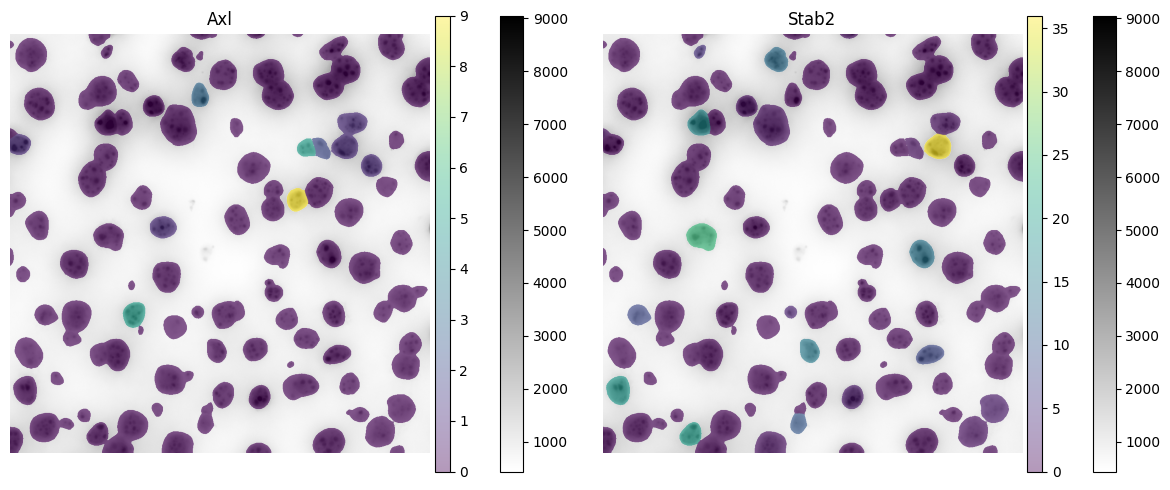

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

channel = "DAPI"
img_layer = "raw_image"
labels_layer = "segmentation_mask"
table_layer = "table_transcriptomics"
crd = [3000, 4000, 3000, 4000]

# normalization parameters for visualization (underlying image not changed)
se = _get_spatial_element(sdata, layer=img_layer)
channel_idx = np.where(sdata[img_layer].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

color = "Axl"
show_kwargs = {
    "title": f"{color}",
    "colorbar": True,
}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    labels_layer=labels_layer,
    table_layer=table_layer,
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = "Stab2"
show_kwargs = {
    "title": f"{color}",
    "colorbar": True,
}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer=img_layer,
    channel=channel,
    crd=crd,
    labels_layer=labels_layer,
    table_layer=table_layer,
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()